In [12]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
plt.style.use('fivethirtyeight')

In [2]:
#read data
df = pd.read_csv('furniture.csv',parse_dates=['Order Date'])

In [3]:
df.head()

Order Date     Sales
0 2014-01-06  2573.820
1 2014-01-07    76.728
2 2014-01-10    51.940
3 2014-01-11     9.940
4 2014-01-13   879.939

In [4]:
df.tail()

Order Date      Sales
884 2017-12-24  1393.4940
885 2017-12-25   832.4540
886 2017-12-28   551.2568
887 2017-12-29  2330.7180
888 2017-12-30   323.1360

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  889 non-null    datetime64[ns]
 1   Sales       889 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.0 KB


In [6]:
df.describe().T

count        mean          std    min     25%     50%      75%  \
Sales  889.0  834.645439  1015.317163  1.988  173.94  493.92  1128.39   

             max  
Sales  10006.174

In [7]:
df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

### Lets do data processing


### 1) Furniture 

In [8]:
# noting the easrlist and last recorded dates
start = df['Order Date'].min()
end = df['Order Date'].max()
print('start =',start, '\nend = ',end)

start = 2014-01-06 00:00:00 
end =  2017-12-30 00:00:00


<AxesSubplot:xlabel='Order Date'>

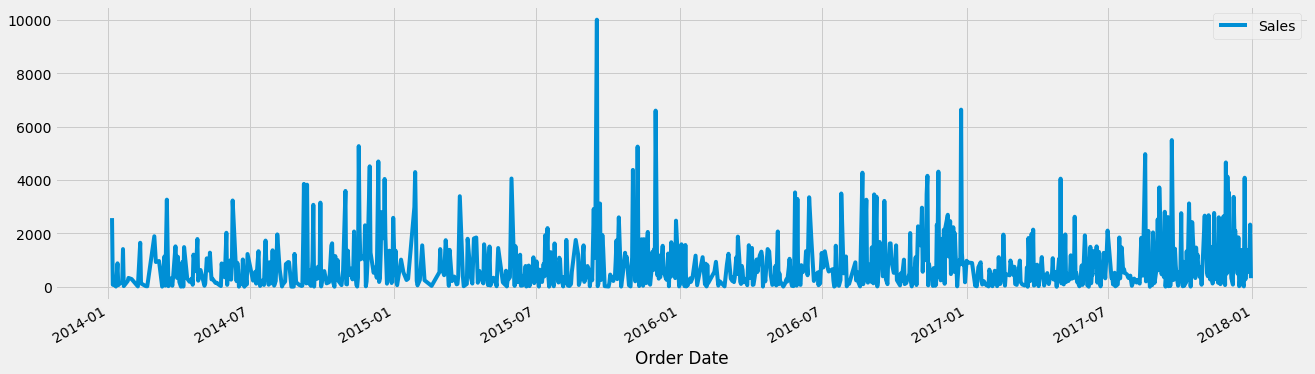

In [14]:
furniture_df = df.sort_values('Order Date')
furniture_df = furniture_df.groupby('Order Date')['Sales'].sum().reset_index()
#setting order date as index
furniture_df = furniture_df.set_index('Order Date')
furniture_df.plot(figsize=(20,6))

Text(0.5, 1.0, 'AVG Monthly Furniture sales')

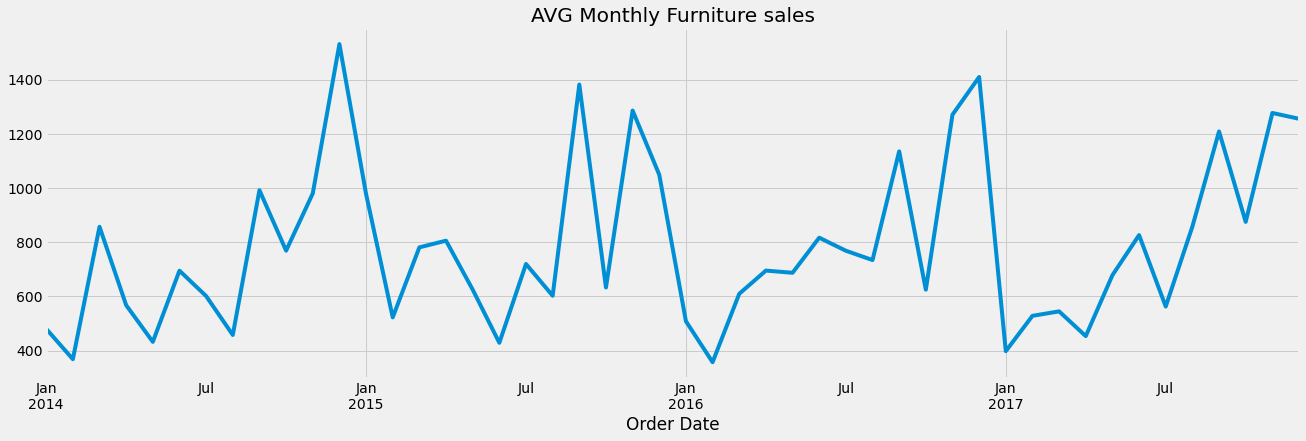

In [18]:
#since there are numerous sales in each month, let's resample the data into tatal monthly sales of furniture and save this into a new variable 
m_furniture = furniture_df['Sales'].resample('M').mean()
m_furniture.plot(figsize=(20,6))
plt.title('AVG Monthly Furniture sales')

**data is clearly not stationary**

In [21]:
# to confirm preform adf test
from statsmodels.tsa.stattools import adfuller
def test_stationariy(series):
    result = adfuller(series)
    print('adf statistics = ',result[0],'\np value =',round(result[1],4))

In [22]:
test_stationariy(m_furniture)

adf statistics =  -5.1910701873392755 
p value = 0.0


p value is higher, data is stationary.so  Lets Proceed

### lets perform ETS decomposition to under stand the ternd and seasonality componenets


In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
furniture_decom = seasonal_decompose(m_furniture,model='addictive')

Text(0.5, 1.0, 'Furniture decomposition')

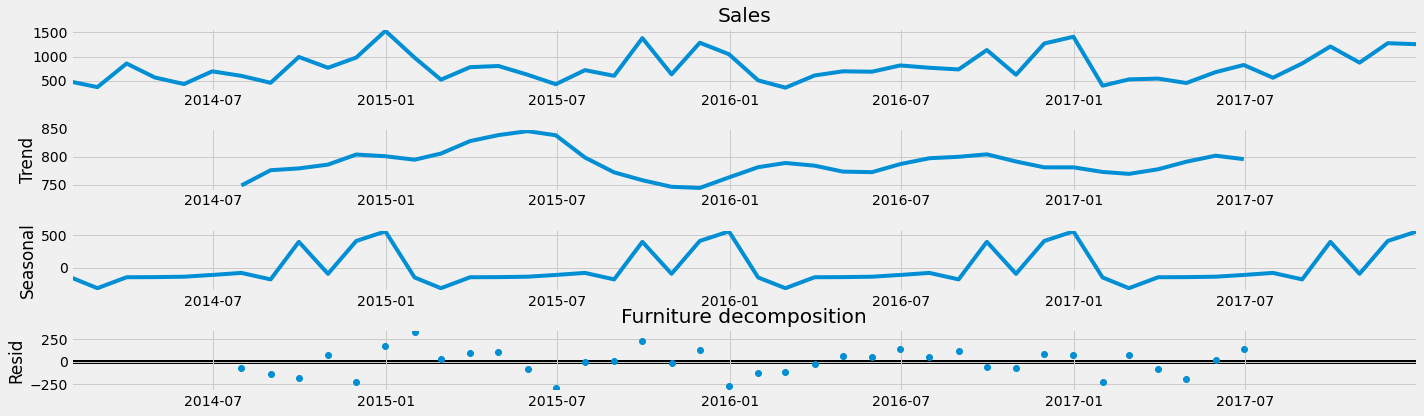

In [29]:
from pylab import rcParams
rcParams['figure.figsize']=20,6
furniture_decom.plot()
plt.title('Furniture decomposition')

Trrends and seasonanliity present

Text(0.5, 1.0, 'Seasonality')

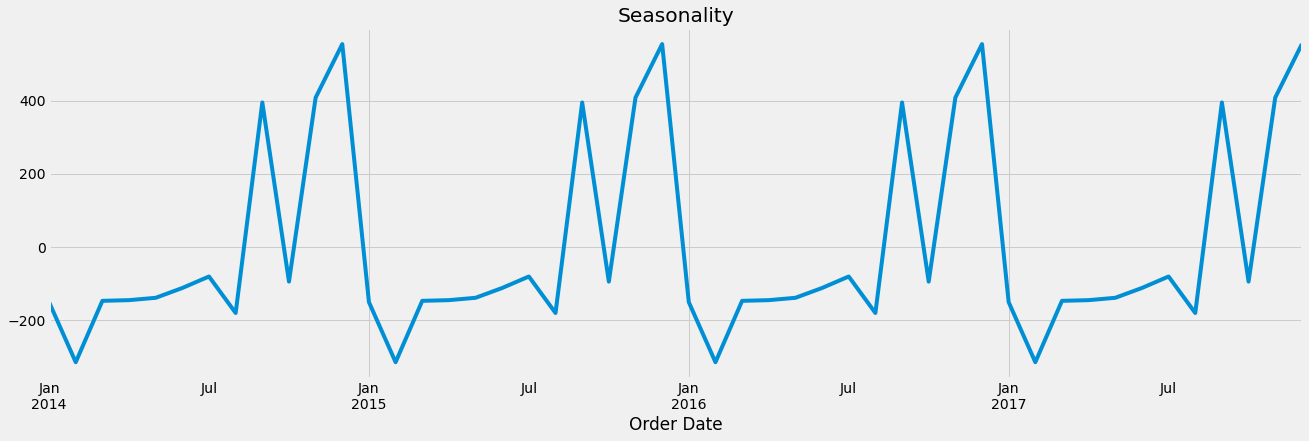

In [31]:
furniture_decom.seasonal.plot()
plt.title('Seasonality')

Text(0.5, 1.0, 'Trend')

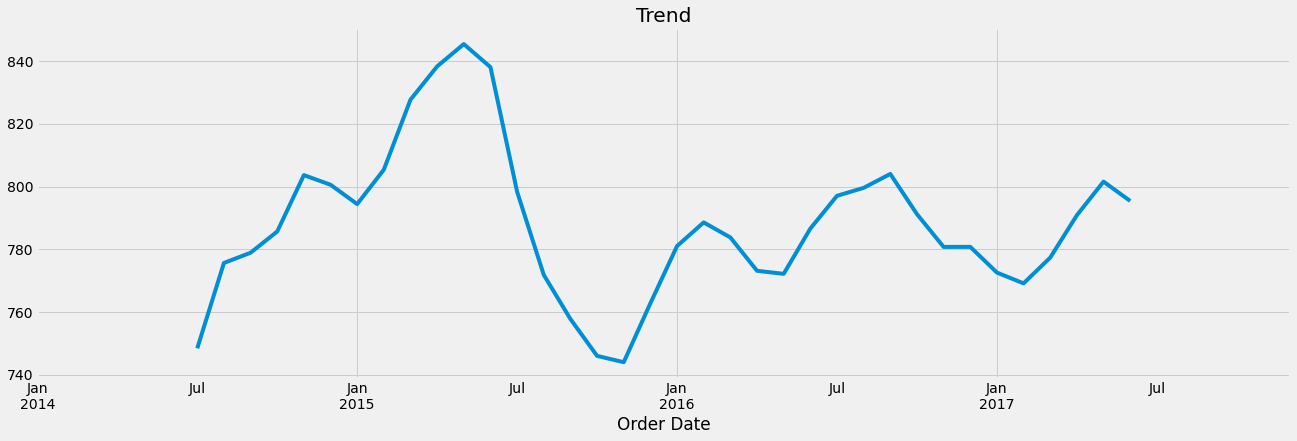

In [127]:
furniture_decom.trend.plot()
plt.title('Trend')

Text(0.5, 1.0, 'Error')

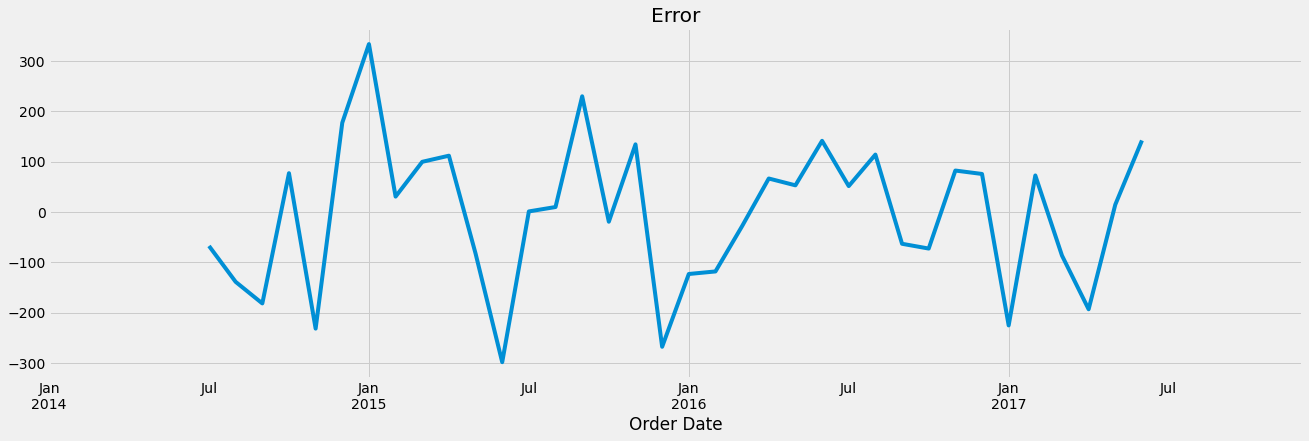

In [32]:
furniture_decom.resid.plot()
plt.title('Error')

# Time Series Analysis With SARIMA 

lets apply the models to the data. we will be using SARIMA from statsmodels library. To find the best order we will use auto armia. but befor that lets plot acf and pacf to get a rough idea

In [42]:
# splitting the data to train test
furniture_train = m_furniture[:36]
furniture_test = m_furniture[36:]

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

C:\Users\vasee\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



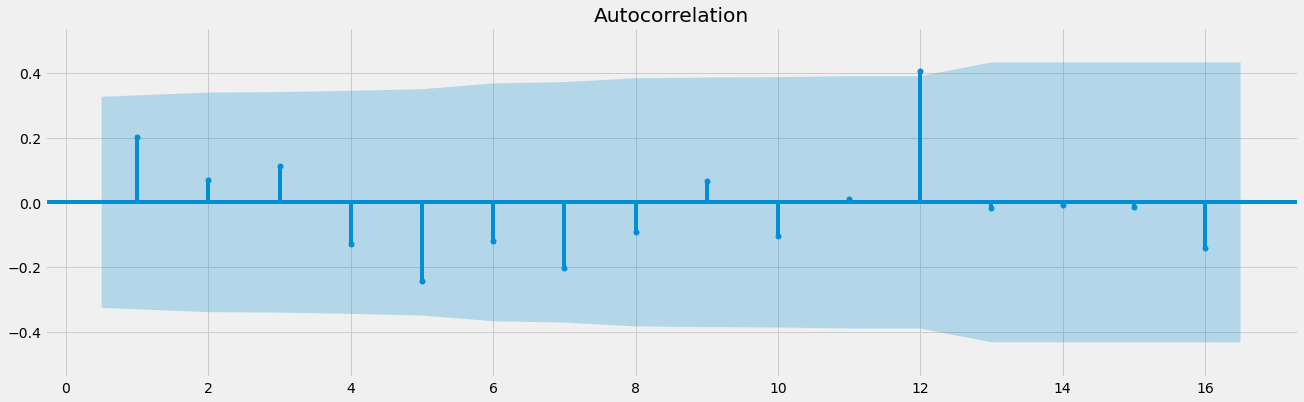

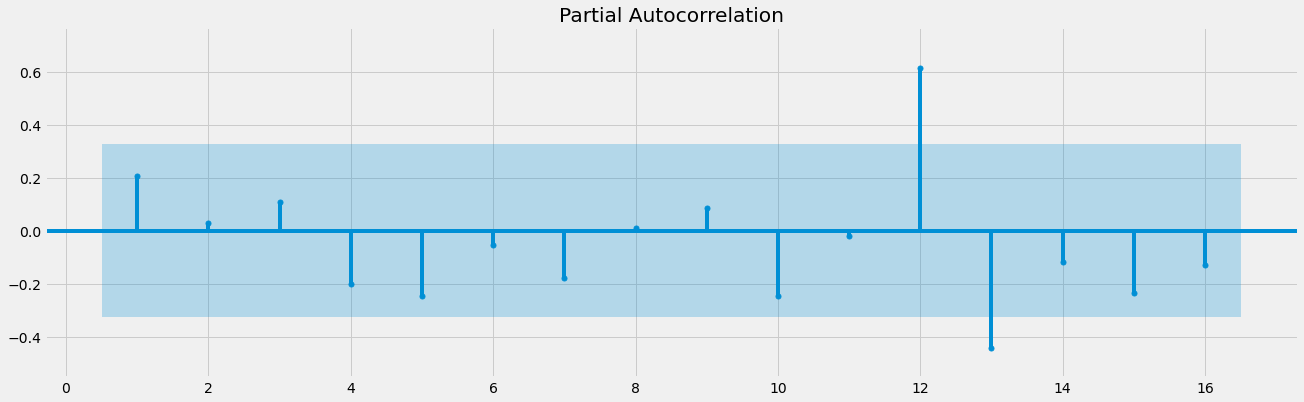

In [130]:
# For furniture
plot_acf(furniture_train,zero = False,auto_ylims= True);
plot_pacf(furniture_train,zero = False,auto_ylims = True);

**Lets apply auto arima to get the best order**

In [131]:
from pmdarima import auto_arima
# for furniture
furniture_order = auto_arima(furniture_train,m=12,seasonal=True,trace=True,max_order = None, max_P=3,max_Q=3)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=338.682, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=330.948, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=337.169, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=340.006, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=333.147, Time=0.52 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=329.174, Time=0.19 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=331.159, Time=0.51 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.83 sec

In [46]:
furniture_order.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   36
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -161.587
Date:                  Wed, 30 Nov 2022   AIC                            329.174
Time:                          14:47:57   BIC                            332.708
Sample:                      01-31-2014   HQIC                           330.111
                           - 12-31-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     74.0420     48.624      1.523      0.128     -21.260     169.344
ar.S.L12      -0.7870      0.131     -6.027      0.000      -1.043      -0.531
sigma2      2.557e+04   1.31e+04      1.946      0.052    -186.539    5.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.92   Prob(JB):                         0.61
Heteroskedasticity (H):               0.77   Skew:                            -0.32
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
# Now lets train the model
from statsmodels.tsa.statespace.sarimax import SARIMAX
furniture_mdl = SARIMAX(furniture_train,order=(0, 0, 0),seasonal_order=(1, 1, 0, 12),enforce_invertibility=False)

In [48]:
furniture_model = furniture_mdl.fit()
furniture_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -162.931
Date:                  Wed, 30 Nov 2022   AIC                            329.863
Time:                          14:48:32   BIC                            332.219
Sample:                      01-31-2014   HQIC                           330.488
                           - 12-31-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7425      0.173     -4.302      0.000      -1.081      -0.404
sigma2      3.027e+04   1.69e+04      1.796      0.073   -2767.917    6.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.98   Prob(JB):                         0.60
Heteroskedasticity (H):               0.88   Skew:                            -0.37
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# Now lets predic with the model
start_date = furniture_test.index[0]
end_date = furniture_test.index[-1]
pred_furniture = furniture_model.predict(start = start_date, end = end_date)

In [50]:
resids = furniture_model.resid

Text(0, 0.5, 'Error')

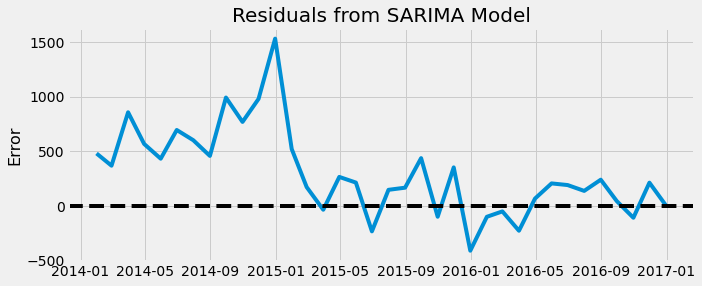

In [51]:
plt.figure(figsize=(10,4))
plt.plot(resids)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

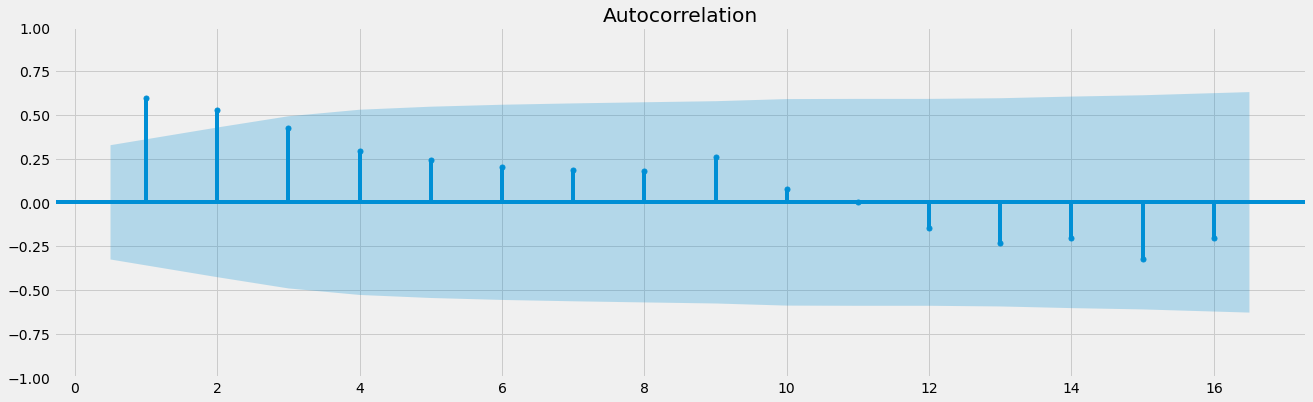

In [54]:
plot_acf(resids,zero = 0);

In [61]:
furniture_mdl2 = SARIMAX(furniture_train,order=(0, 0, 0),seasonal_order=(2, 1, 0, 12),enforce_invertibility=False)
furniture_model2 = furniture_mdl2.fit()
furniture_model2.summary()

C:\Users\vasee\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\vasee\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    Sales   No. Observations:                   36
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                -162.576
Date:                  Wed, 30 Nov 2022   AIC                            331.151
Time:                          15:06:42   BIC                            334.685
Sample:                      01-31-2014   HQIC                           332.089
                           - 12-31-2016                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0141      0.010     -1.386      0.166      -0.034       0.006
ar.S.L24       0.9814      0.010     94.545      0.000       0.961       1.002
sigma2      1086.2239    3.1e-07   3.51e+09      0.000    1086.224    1086.224
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.95   Prob(JB):                         0.60
Heteroskedasticity (H):               0.81   Skew:                            -0.33
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.66e+25. Standard errors may be unstable.
"""

### Evaluating

In [55]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [56]:
print('mae:',mean_absolute_error(furniture_test,pred_furniture),'\nrmse:',rmse(furniture_test,pred_furniture))

mae: 185.3392428628589 
rmse: 225.19100511081723


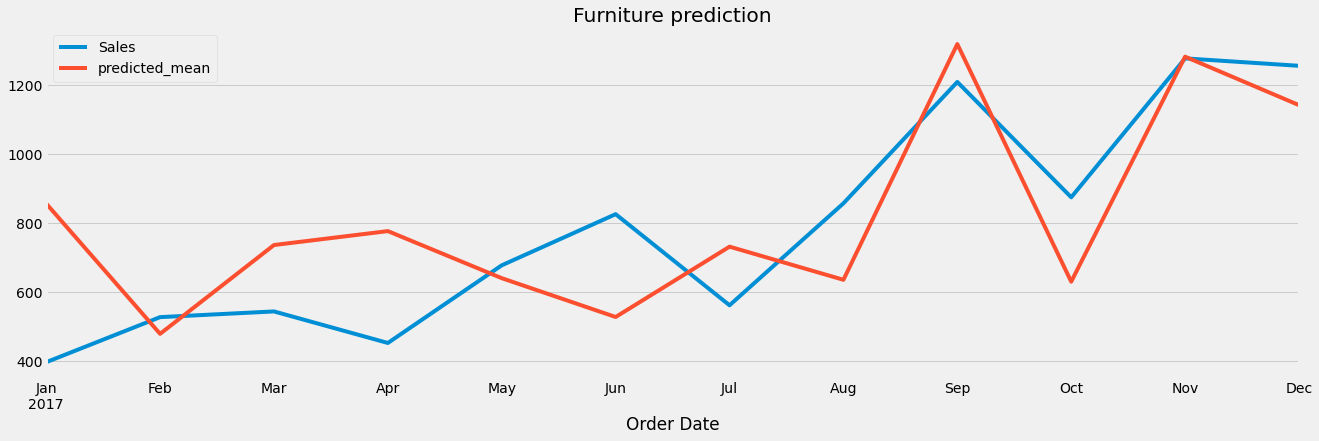

In [57]:
furniture_test.plot()
pred_furniture.plot()
plt.title("Furniture prediction")
plt.legend()

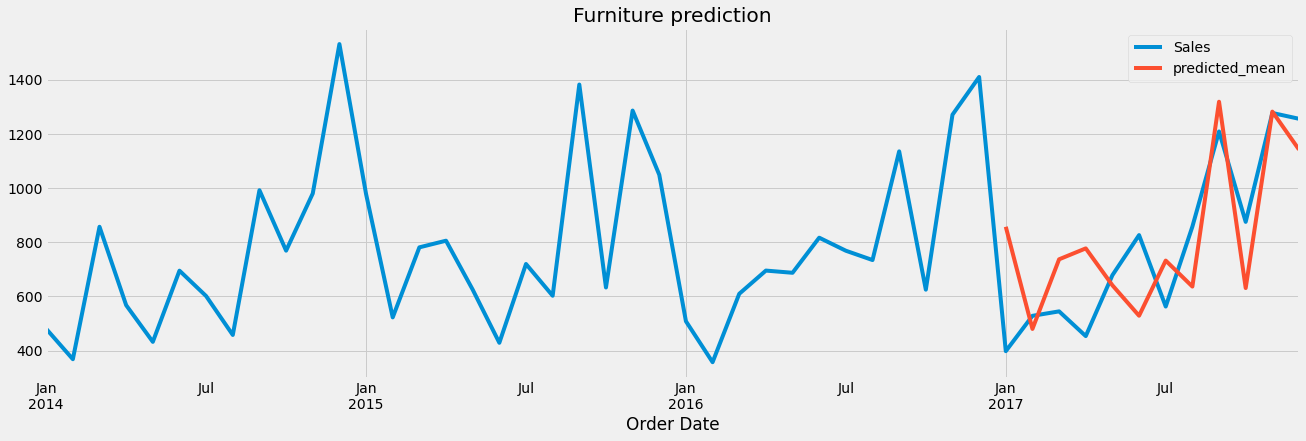

In [58]:
m_furniture.plot()
pred_furniture.plot()
plt.title("Furniture prediction")
plt.legend()

### Now let us forecast into the unknown future

In [62]:
final_fur_model = SARIMAX(m_furniture,order=(0, 0, 0),seasonal_order=(1, 1, 0, 12),enforce_invertibility=False)
furniture_model_final = final_fur_model.fit()
forecast_furniture = furniture_model_final.forecast(steps = 12)

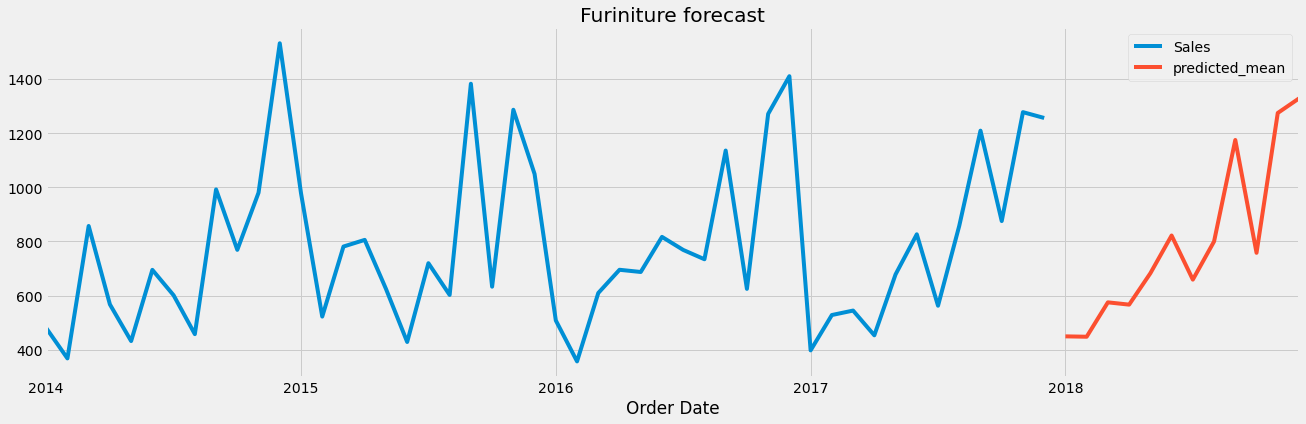

In [63]:
m_furniture.plot()
forecast_furniture.plot()
plt.title("Furiniture forecast")
plt.legend()

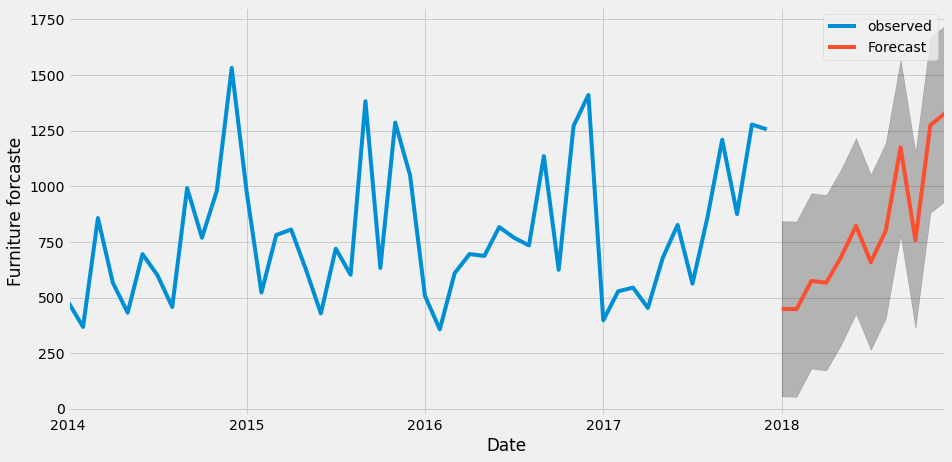

In [64]:
pred_furn = furniture_model_final.get_forecast(steps=12)
pred_ci_furn = pred_furn.conf_int()
ax = m_furniture.plot(label='observed',figsize=(14,7))
pred_furn.predicted_mean.plot(ax=ax,label='Forecast')
ax.fill_between(pred_ci_furn.index,
               pred_ci_furn.iloc[:,0],
               pred_ci_furn.iloc[:,1],color='k',alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture forcaste')
plt.legend()
plt.show()

# Time series modelling with prophet

In [65]:
p_furniture = pd.DataFrame({'y':m_furniture, 'ds': m_furniture.index})

In [67]:
p_furniture.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-31 to 2017-12-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       48 non-null     float64       
 1   ds      48 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [74]:
# splitting the data to train test
train = p_furniture[:36]
test = p_furniture[36:]

In [82]:
len(train)

36

In [132]:
# Now lets predic with the model
start_date = furniture_test.index[0]
end_date = furniture_test.index[-1]
prophet_model = Prophet()
prophet_model.fit(train)

17:44:43 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
forecast_date = prophet_model.make_future_dataframe(periods=12,freq='M')
prophet_predict = prophet_model.predict(forecast_date)
prophet_predict

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  2014-01-31  660.936963   524.869366   825.694795   660.936963   660.936963   
1  2014-02-28  664.659127   227.649847   514.788972   664.659127   664.659127   
2  2014-03-31  668.780094   565.499688   873.192520   668.780094   668.780094   
3  2014-04-30  672.768127   510.930699   799.515814   672.768127   672.768127   
4  2014-05-31  676.889095   381.011169   667.267247   676.889095   676.889095   
5  2014-06-30  680.877128   410.808202   719.458627   680.877128   680.877128   
6  2014-07-31  684.998095   497.113303   798.848298   684.998095   684.998095   
7  2014-08-31  689.119062   388.530263   680.434706   689.119062   689.119062   
8  2014-09-30  693.107095  1011.507115  1290.143975   693.107095   693.107095   
9  2014-10-31  697.228063   489.060799   788.833362   697.228063   697.228063   
10 2014-11-30  701.216096   985.585325  1291.007390   701.216096   701.216096   
11 2014-12-31  705.337063  1122.081892  1415.591672   705.337063   705.337063   
12 2015-01-31  709.458031   507.704811   801.407292   709.458031   709.458031   
13 2015-02-28  713.180195   343.391072   634.223522   713.180195   713.180195   
14 2015-03-31  717.301162   697.612063   989.003473   717.301162   717.301162   
15 2015-04-30  721.289195   587.150376   888.559303   721.289195   721.289195   
16 2015-05-31  725.409983   410.990765   703.773930   725.409983   725.409983   
17 2015-06-30  729.397843   376.707324   657.758488   729.397843   729.397843   
18 2015-07-31  733.518631   551.886926   845.131410   733.518631   733.518631   
19 2015-08-31  737.639419   399.970943   708.596085   737.639419   737.639419   
20 2015-09-30  741.627278  1144.716609  1425.682762   741.627278   741.627278   
21 2015-10-31  745.748067   577.891006   861.955181   745.748067   745.748067   
22 2015-11-30  749.735926  1032.782149  1328.784837   749.735926   749.735926   
23 2015-12-31  753.856714  1072.362624  1368.477119   753.856714   753.856714   
24 2016-01-31  757.977502   494.295277   777.991048   757.977502   757.977502   
25 2016-02-29  761.832433   243.161412   524.397995   761.832433   761.832433   
26 2016-03-31  765.953221   532.503036   825.201431   765.953221   765.953221   
27 2016-04-30  769.941081   533.267582   831.795641   769.941081   769.941081   
28 2016-05-31  774.061869   521.618171   808.879465   774.061869   774.061869   
29 2016-06-30  778.049729   706.484676  1005.097507   778.049729   778.049729   
30 2016-07-31  782.170517   608.819798   900.283002   782.170517   782.170517   
31 2016-08-31  786.291305   552.116268   844.683864   786.291305   786.291305   
32 2016-09-30  790.279164   918.770209  1214.623454   790.279164   790.279164   
33 2016-10-31  794.399952   522.593522   817.785463   794.399952   794.399952   
34 2016-11-30  798.387812  1071.423515  1374.513192   798.387812   798.387812   
35 2016-12-31  802.508600  1363.161684  1655.088502   802.508600   802.508600   
36 2017-01-31  806.629388   745.721063  1046.018968   806.629383   806.629393   
37 2017-02-28  810.351390   338.336864   624.096688   810.351374   810.351407   
38 2017-03-31  814.472178   645.446115   941.704162   814.472146   814.472208   
39 2017-04-30  818.460038   619.075929   911.860297   818.459988   818.460086   
40 2017-05-31  822.580826   533.194797   836.686572   822.580756   822.580894   
41 2017-06-30  826.568686   656.480102   942.344302   826.568593   826.568777   
42 2017-07-31  830.689474   641.434443   937.147959   830.689355   830.689589   
43 2017-08-31  834.810262   557.325869   857.759823   834.810113   834.810400   
44 2017-09-30  838.798121  1067.673926  1354.696052   838.797942   838.798284   
45 2017-10-31  842.918909   590.561949   894.019433   842.918701   842.919101   
46 2017-11-30  846.906769  1131.622361  1429.008318   846.906530   846.906992   
47 2017-12-31  851.027557  1344.038555  1614.896241   851.027282   851.027814   

    additive_terms  additive_terms_lower 

In [80]:
prophet_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [94]:
pred_prof = prophet_predict[['yhat','ds']][36:]

In [95]:
pred_prof.set_index('ds',inplace=True)

In [97]:
pred_prof

yhat
ds                     
2017-01-31   897.461484
2017-02-28   477.051947
2017-03-31   798.324627
2017-04-30   766.340930
2017-05-31   692.387657
2017-06-30   807.939053
2017-07-31   791.706099
2017-08-31   711.994666
2017-09-30  1206.866346
2017-10-31   748.097894
2017-11-30  1275.640732
2017-12-31  1482.644503

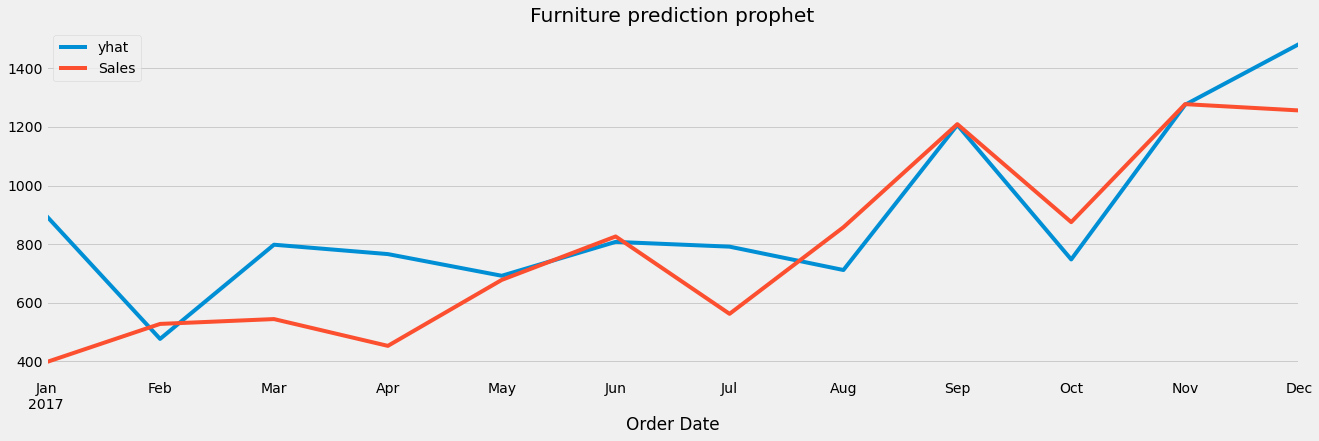

In [102]:
pred_prof.plot()
furniture_test.plot()
plt.title("Furniture prediction prophet")
plt.legend()

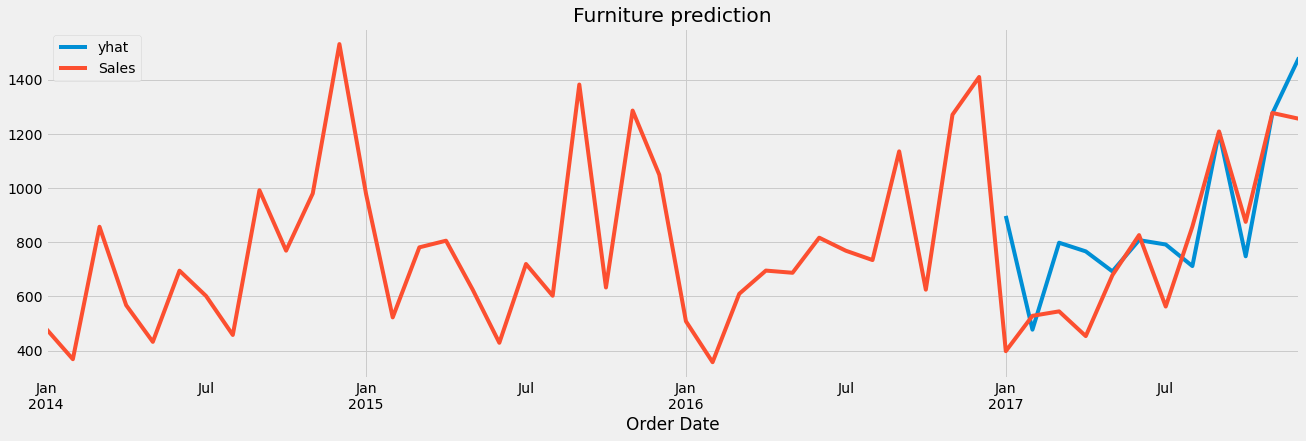

In [104]:
pred_prof.plot()
m_furniture.plot()
plt.title("Furniture prediction")
plt.legend()

In [125]:
print('mae:',mean_absolute_error(furniture_test,pred_prof))

mae: 156.9822980394893


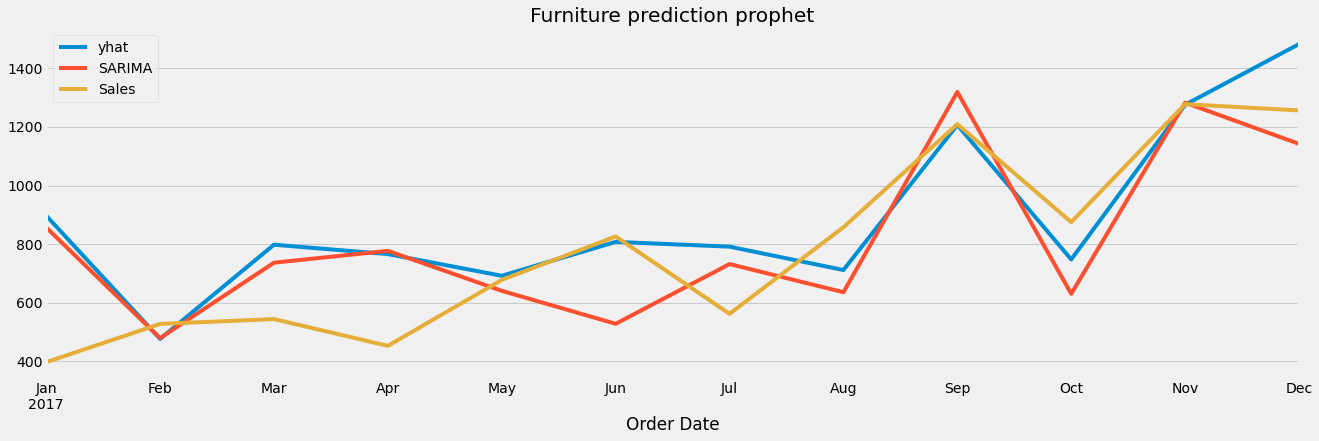

In [109]:
pred_prof.plot(label = 'Prophet')
pred_furniture.plot(label = 'SARIMA')
furniture_test.plot(label = 'Sales')
plt.title("Furniture prediction prophet")
plt.legend()
plt.show()

## Forcasting

In [110]:
forecast_date = prophet_model.make_future_dataframe(periods=12,freq='M')

In [111]:
prophet_forecast = prophet_model.predict(forecast_date)

In [112]:
prophet_forecast

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0  2014-01-31  660.936963   545.057383   827.812968   660.936963   660.936963   
1  2014-02-28  664.659127   233.740026   524.409315   664.659127   664.659127   
2  2014-03-31  668.780094   587.519120   868.343795   668.780094   668.780094   
3  2014-04-30  672.768127   504.484865   805.284079   672.768127   672.768127   
4  2014-05-31  676.889095   373.256681   673.197408   676.889095   676.889095   
5  2014-06-30  680.877128   423.874053   701.977477   680.877128   680.877128   
6  2014-07-31  684.998095   505.896965   791.293406   684.998095   684.998095   
7  2014-08-31  689.119062   393.289977   683.868692   689.119062   689.119062   
8  2014-09-30  693.107095  1010.461130  1287.699741   693.107095   693.107095   
9  2014-10-31  697.228063   494.248455   781.749783   697.228063   697.228063   
10 2014-11-30  701.216096   984.045986  1287.338417   701.216096   701.216096   
11 2014-12-31  705.337063  1107.370678  1404.010634   705.337063   705.337063   
12 2015-01-31  709.458031   508.788507   807.597335   709.458031   709.458031   
13 2015-02-28  713.180195   345.322476   633.859012   713.180195   713.180195   
14 2015-03-31  717.301162   690.276098   989.532817   717.301162   717.301162   
15 2015-04-30  721.289195   579.928985   870.405930   721.289195   721.289195   
16 2015-05-31  725.409983   404.250333   704.826453   725.409983   725.409983   
17 2015-06-30  729.397843   381.815452   659.768075   729.397843   729.397843   
18 2015-07-31  733.518631   553.453397   838.772122   733.518631   733.518631   
19 2015-08-31  737.639419   421.744425   709.777037   737.639419   737.639419   
20 2015-09-30  741.627278  1149.223572  1437.248404   741.627278   741.627278   
21 2015-10-31  745.748067   586.002379   877.515827   745.748067   745.748067   
22 2015-11-30  749.735926  1040.803391  1328.676447   749.735926   749.735926   
23 2015-12-31  753.856714  1073.094877  1379.121440   753.856714   753.856714   
24 2016-01-31  757.977502   482.696653   780.094729   757.977502   757.977502   
25 2016-02-29  761.832433   235.039896   525.433504   761.832433   761.832433   
26 2016-03-31  765.953221   525.249372   817.647086   765.953221   765.953221   
27 2016-04-30  769.941081   528.397857   821.647238   769.941081   769.941081   
28 2016-05-31  774.061869   511.442125   797.609644   774.061869   774.061869   
29 2016-06-30  778.049729   718.596316   998.166574   778.049729   778.049729   
30 2016-07-31  782.170517   596.232477   895.497586   782.170517   782.170517   
31 2016-08-31  786.291305   539.681196   834.840312   786.291305   786.291305   
32 2016-09-30  790.279164   921.163378  1203.569441   790.279164   790.279164   
33 2016-10-31  794.399952   521.707939   796.087814   794.399952   794.399952   
34 2016-11-30  798.387812  1073.083389  1358.146561   798.387812   798.387812   
35 2016-12-31  802.508600  1365.114320  1652.353157   802.508600   802.508600   
36 2017-01-31  806.629388   754.584872  1047.718693   806.629383   806.629394   
37 2017-02-28  810.351390   339.393738   621.631807   810.351375   810.351408   
38 2017-03-31  814.472178   645.454585   945.720033   814.472150   814.472211   
39 2017-04-30  818.460038   627.332213   905.833912   818.459992   818.460086   
40 2017-05-31  822.580826   537.721692   841.715249   822.580759   822.580897   
41 2017-06-30  826.568686   670.195578   962.216847   826.568596   826.568779   
42 2017-07-31  830.689474   643.983086   940.014028   830.689359   830.689593   
43 2017-08-31  834.810262   565.562660   862.933308   834.810126   834.810408   
44 2017-09-30  838.798121  1058.838038  1346.237388   838.797958   838.798294   
45 2017-10-31  842.918909   595.791099   904.610652   842.918722   842.919113   
46 2017-11-30  846.906769  1143.221136  1425.781641   846.906554   846.907003   
47 2017-12-31  851.027557  1326.870731  1626.282455   851.027312   851.027815   

    additive_terms  additive_terms_lower 

In [113]:
prophet_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [114]:
prophet_forecast[['ds','yhat_lower', 'yhat_upper','yhat']].tail(12)

ds   yhat_lower   yhat_upper         yhat
36 2017-01-31   754.584872  1047.718693   897.461484
37 2017-02-28   339.393738   621.631807   477.051947
38 2017-03-31   645.454585   945.720033   798.324627
39 2017-04-30   627.332213   905.833912   766.340930
40 2017-05-31   537.721692   841.715249   692.387657
41 2017-06-30   670.195578   962.216847   807.939053
42 2017-07-31   643.983086   940.014028   791.706099
43 2017-08-31   565.562660   862.933308   711.994666
44 2017-09-30  1058.838038  1346.237388  1206.866346
45 2017-10-31   595.791099   904.610652   748.097894
46 2017-11-30  1143.221136  1425.781641  1275.640732
47 2017-12-31  1326.870731  1626.282455  1482.644503

In [115]:
from prophet.plot import plot_plotly, plot_components_plotly

In [116]:
plot_plotly(prophet_model, prophet_forecast)

In [126]:
plot_components_plotly(prophet_model , prophet_forecast)